In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import keras 
import os
import random
from datetime import datetime

from keras.models import Sequential
from keras.layers import Input,  Conv2D, MaxPooling2D, Dense, Flatten, Dropout, SpatialDropout2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, Activation
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2 # type: ignore
from keras_tuner import Hyperband
from keras_tuner.applications import HyperResNet

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras import mixed_precision # type: ignore
from keras.layers import RandomFlip, RandomContrast, RandomBrightness, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Resizing


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [7]:
DIR = '../data/playing_cards_dataset/'
TRAIN_DIR = DIR + 'train/'
TEST_DIR = DIR + 'test/'
VAL_DIR = DIR + 'valid/'
LOG_DIR = '../logs/'

EPOCHS = 100
BATCH_SIZE = 64

In [11]:

# Reading images from folders
train_dataset = keras.utils.image_dataset_from_directory(TRAIN_DIR, image_size=(224, 224), batch_size=BATCH_SIZE)
test_dataset = keras.utils.image_dataset_from_directory(TEST_DIR, image_size=(224, 224), shuffle='false', batch_size=BATCH_SIZE)
val_dataset = keras.utils.image_dataset_from_directory(VAL_DIR, image_size=(224, 224), shuffle='flase', batch_size=BATCH_SIZE)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [12]:
CLASSES = train_dataset.class_names
NUM_CLASSES = len(CLASSES)
IMG_SHAPE = (224, 224, 3)

In [13]:
img_augmentation_layers = [
    RandomContrast(0.2),
    RandomBrightness(0.2),
    RandomRotation(0.03, fill_mode='constant'),
    RandomZoom(height_factor=(-0.1, 0.0), width_factor=(-0.1, 0.0)), 
    # RandomErasing(factor=0.5), # Not available in current keras version
    Resizing(224, 224)
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

def preprocess(image, label): # Scaling pixels to range 0-1
    image = tf.cast(image, tf.float32) / 255
    return image, label

def preprocess_and_augment(image, label):
    image = img_augmentation(image)
    image, label = preprocess(image, label)
    return image, label

In [14]:
train_dataset = train_dataset.map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
def evaluate_model(model, dataset=test_dataset, num_classes= NUM_CLASSES, classes= CLASSES):
    # Core metrics
    loss, accuracy = model.evaluate(dataset, verbose=0)
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')

    # Gather batch predictions
    y_pred, y_true, y_pred_probs = [], [], []
    for images, labels in dataset:
        batch_pred = model.predict(images, verbose=0)
        y_pred_probs.extend(batch_pred)
        y_pred.extend(tf.argmax(batch_pred, axis=1).numpy())  
        y_true.extend(labels.numpy())  
        
    precision = precision_score(y_true, y_pred, average='macro')
    print(f'Precision: {precision}')
    recall = recall_score(y_true, y_pred, average='macro')
    print(f'Recall: {recall}')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f'F1: {f1}')
    
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    auc_macro = roc_auc_score(y_true_bin, y_pred_probs, average='macro', multi_class='ovr')
    print(f"ROC AUC: {auc_macro}")

    # Classification report
    class_report = classification_report(y_true, y_pred, target_names=classes)
    print("\nClassification Report:")
    print(class_report)
    
    conf_maxtrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    plot_confustion_matrix(conf_maxtrix)
        
def plot_confustion_matrix(cm, classes=CLASSES):
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, linewidths=.5, cbar=False)
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
def plot_training_history(training, model_name='Model'):
    acc = training.history['accuracy']
    val_acc = training.history['val_accuracy']
    loss = training.history['loss']
    val_loss = training.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)

    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ), 
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5, 
        patience=1,
        min_lr=1e-8,
        verbose=1,
    )
]

# CNN Hypermodel Tuning

In [ ]:
def build_hypermodel(hp):
    
    num_blocks = hp.Int('num_conv_blocks', min_value=2, max_value=5)
    initial_filters = hp.Choice('initial_filters', values=[8, 16, 32])
    spacial_dropout = hp.Float('spacial_dropout', min_value=0.1, max_value=0.4, step=0.05)
    
    dense_units = hp.Choice('desne_units', values=[128, 256, 512])
    dense_dropout = hp.Float('dense_dropout', min_value=0.2, max_value=0.6, step=0.05)
    
    optimizer_name = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    layers = [
        Input(shape= IMG_SHAPE),
    ]
    
    for i in range(num_blocks):
        filters = initial_filters * (2**i)
        layers.extend([
            Conv2D(filters, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            SpatialDropout2D(spacial_dropout),
        ])
        
    layers.extend([
        Flatten(),
        Dense(dense_units, activation='relu'),
        BatchNormalization(),
        Dropout(dense_dropout),
        Dense(NUM_CLASSES, activation='softmax'),
    ])
    
    hypermodel = Sequential(layers)
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
        
    hypermodel.compile(
        optimizer=optimizer, 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'])
        
    return hypermodel

In [ ]:
tuner = Hyperband(
    build_hypermodel,
    objective='val_accuracy',
    directory= LOG_DIR + 'tuning/cnn', 
    project_name='keras_tuner',
)

In [ ]:
tuner.search(
    train_dataset,
    validation_data = val_dataset,
    callbacks = [
        TensorBoard(LOG_DIR + f'tuning/mobileNetv2/tensorboard/{datetime.now().strftime("%Y%m%d-%H%M%S")}')
    ],
    verbose = 1
)

In [ ]:
# Displaying top 10 hyperparam configurations
cnn_best_hps = tuner.get_best_hyperparameters(num_trials=10)
cnn_hp_list = []

for i, hp in enumerate(cnn_best_hps, start=1):
    hp_dict = hp.values.copy()
    cnn_hp_list.append(hp_dict)

pd.DataFrame(cnn_hp_list)

In [ ]:
# Rebuild the best model
best_cnn_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_cnn = tuner.hypermodel.build(best_cnn_hp)

In [ ]:
training = best_cnn.fit(
    train_dataset, 
    epochs = 10,
    validation_data = val_dataset,
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=2),
    ],
    verbose = 1,
)

In [ ]:
plot_training_history(training, 'Tuned CNN')

In [ ]:
evaluate_model(best_cnn, test_dataset)

In [ ]:
# best_cnn.save('../models/tuned_cnn.h5')

# MobileNetV2 Hypermodel Tuning 

In [15]:
def build_mobileNetV2_hypermodel(hp):
    num_dense_layers = hp.Int('num_pred_layers', min_value=1, max_value=5)
    init_pred_units = hp.Choice('init_pred_units', values=[128, 256, 512, 1024])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.6, step=0.1)
    
    base_model = MobileNetV2(
        input_shape=IMG_SHAPE, 
        weights='imagenet', 
        include_top=False
    )
    
    base_model.trainable = False
    
    units = init_pred_units
    
    inputs = Input(shape=IMG_SHAPE)
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    for i in range(num_dense_layers):    
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
        units = max(32, units // 2)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    transfer_model = keras.Model(inputs, outputs)
    
    transfer_model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
    return transfer_model

In [16]:
tuner = Hyperband(
    build_mobileNetV2_hypermodel,
    objective='val_accuracy',
    directory= LOG_DIR + 'tuning/mobileNetv2', 
    project_name='keras_tuner',
)

In [ ]:
tuner.search(
    train_dataset,
    validation_data = val_dataset,
    callbacks = [TensorBoard(LOG_DIR + f'tuning/mobileNetv2/tensorboard/{datetime.now().strftime("%Y%m%d-%H%M%S")}')],
    verbose = 1)

Reloading Tuner from ../logs/tuning/mobileNetv2\keras_tuner\tuner0.json


In [17]:
# Displaying top 10 hyperparam configurations
mobileNetV2_best_hps = tuner.get_best_hyperparameters(num_trials=10)
mobileNetV2_hp_list = []

for i, hp in enumerate(cnn_best_hps, start=1):
    hp_dict = hp.values.copy()
    mobileNetV2_hp_list.append(hp_dict)

pd.DataFrame(mobileNetV2_hp_list)

[]

In [ ]:
# Rebuild the best model
best_mobileNetV2_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_mobileNetV2 = tuner.hypermodel.build(best_mobileNetV2_hp)

In [ ]:
# Pretraining
training = best_mobileNetV2.fit(
    train_dataset, 
    epochs = 10,
    validation_data = val_dataset,
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=2),
    ],
    verbose = 1,
)

Epoch 1/10
120/120 [==============================] - 9s 36ms/step - loss: 3.4514 - accuracy: 0.1086 - val_loss: 3.7032 - val_accuracy: 0.0491
Epoch 2/10
120/120 [==============================] - 6s 33ms/step - loss: 2.8550 - accuracy: 0.2068 - val_loss: 3.4739 - val_accuracy: 0.0755
Epoch 3/10
120/120 [==============================] - 6s 33ms/step - loss: 2.6026 - accuracy: 0.2673 - val_loss: 3.5599 - val_accuracy: 0.0906
Epoch 4/10
120/120 [==============================] - 6s 33ms/step - loss: 2.4259 - accuracy: 0.3098 - val_loss: 3.5176 - val_accuracy: 0.0906
Epoch 5/10
120/120 [==============================] - 6s 33ms/step - loss: 2.2805 - accuracy: 0.3473 - val_loss: 3.5470 - val_accuracy: 0.1019
Epoch 6/10
120/120 [==============================] - 6s 32ms/step - loss: 2.1782 - accuracy: 0.3694 - val_loss: 3.6772 - val_accuracy: 0.0943
Epoch 7/10
120/120 [==============================] - 6s 32ms/step - loss: 2.0928 - accuracy: 0.3942 - val_loss: 3.6871 - val_accuracy: 0.0906

In [ ]:
# Unfreezing MobileNetV2 layers
for layer in best_mobileNetV2.layers[-20:]:
      if not isinstance(layer, BatchNormalization):
         layer.trainable = True
         
best_mobileNetV2.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine tuning 
training = best_mobileNetV2.fit(
    train_dataset, 
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = callbacks,
    verbose = 1,
)

Epoch 1/100
120/120 [==============================] - 21s 124ms/step - loss: 0.3305 - accuracy: 0.8966 - val_loss: 4.3796 - val_accuracy: 0.0226 - lr: 9.7656e-08
Epoch 2/100
120/120 [==============================] - 18s 119ms/step - loss: 0.3416 - accuracy: 0.8928 - val_loss: 4.4931 - val_accuracy: 0.0264 - lr: 9.7656e-08
Epoch 3/100
 89/120 [=====================>........] - ETA: 3s - loss: 0.3249 - accuracy: 0.8991

KeyboardInterrupt: 

In [ ]:
plot_training_history(training, 'Tuned MobileNetV2')

Loss: 4.552554607391357
Accuracy: 0.022641509771347046


c:\Users\james\anaconda3\envs\gpu-machine-learning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\envs\gpu-machine-learning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\envs\gpu-machine-learning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

Precision: 0.001067995728017088
Recall: 0.022641509433962266
F1: 0.0019968278620449797
ROC AUC: 0.56

Classification Report:
                   precision    recall  f1-score   support

     ace of clubs       0.00      0.00      0.00         5
  ace of diamonds       0.00      0.00      0.00         5
    ace of hearts       0.00      0.00      0.00         5
    ace of spades       0.00      0.00      0.00         5
   eight of clubs       0.00      0.00      0.00         5
eight of diamonds       0.00      0.00      0.00         5
  eight of hearts       0.00      0.00      0.00         5
  eight of spades       0.00      0.00      0.00         5
    five of clubs       0.00      0.00      0.00         5
 five of diamonds       0.00      0.00      0.00         5
   five of hearts       0.00      0.00      0.00         5
   five of spades       0.00      0.00      0.00         5
    four of clubs       0.00      0.00      0.00         5
 four of diamonds       0.00      0.00      0.00

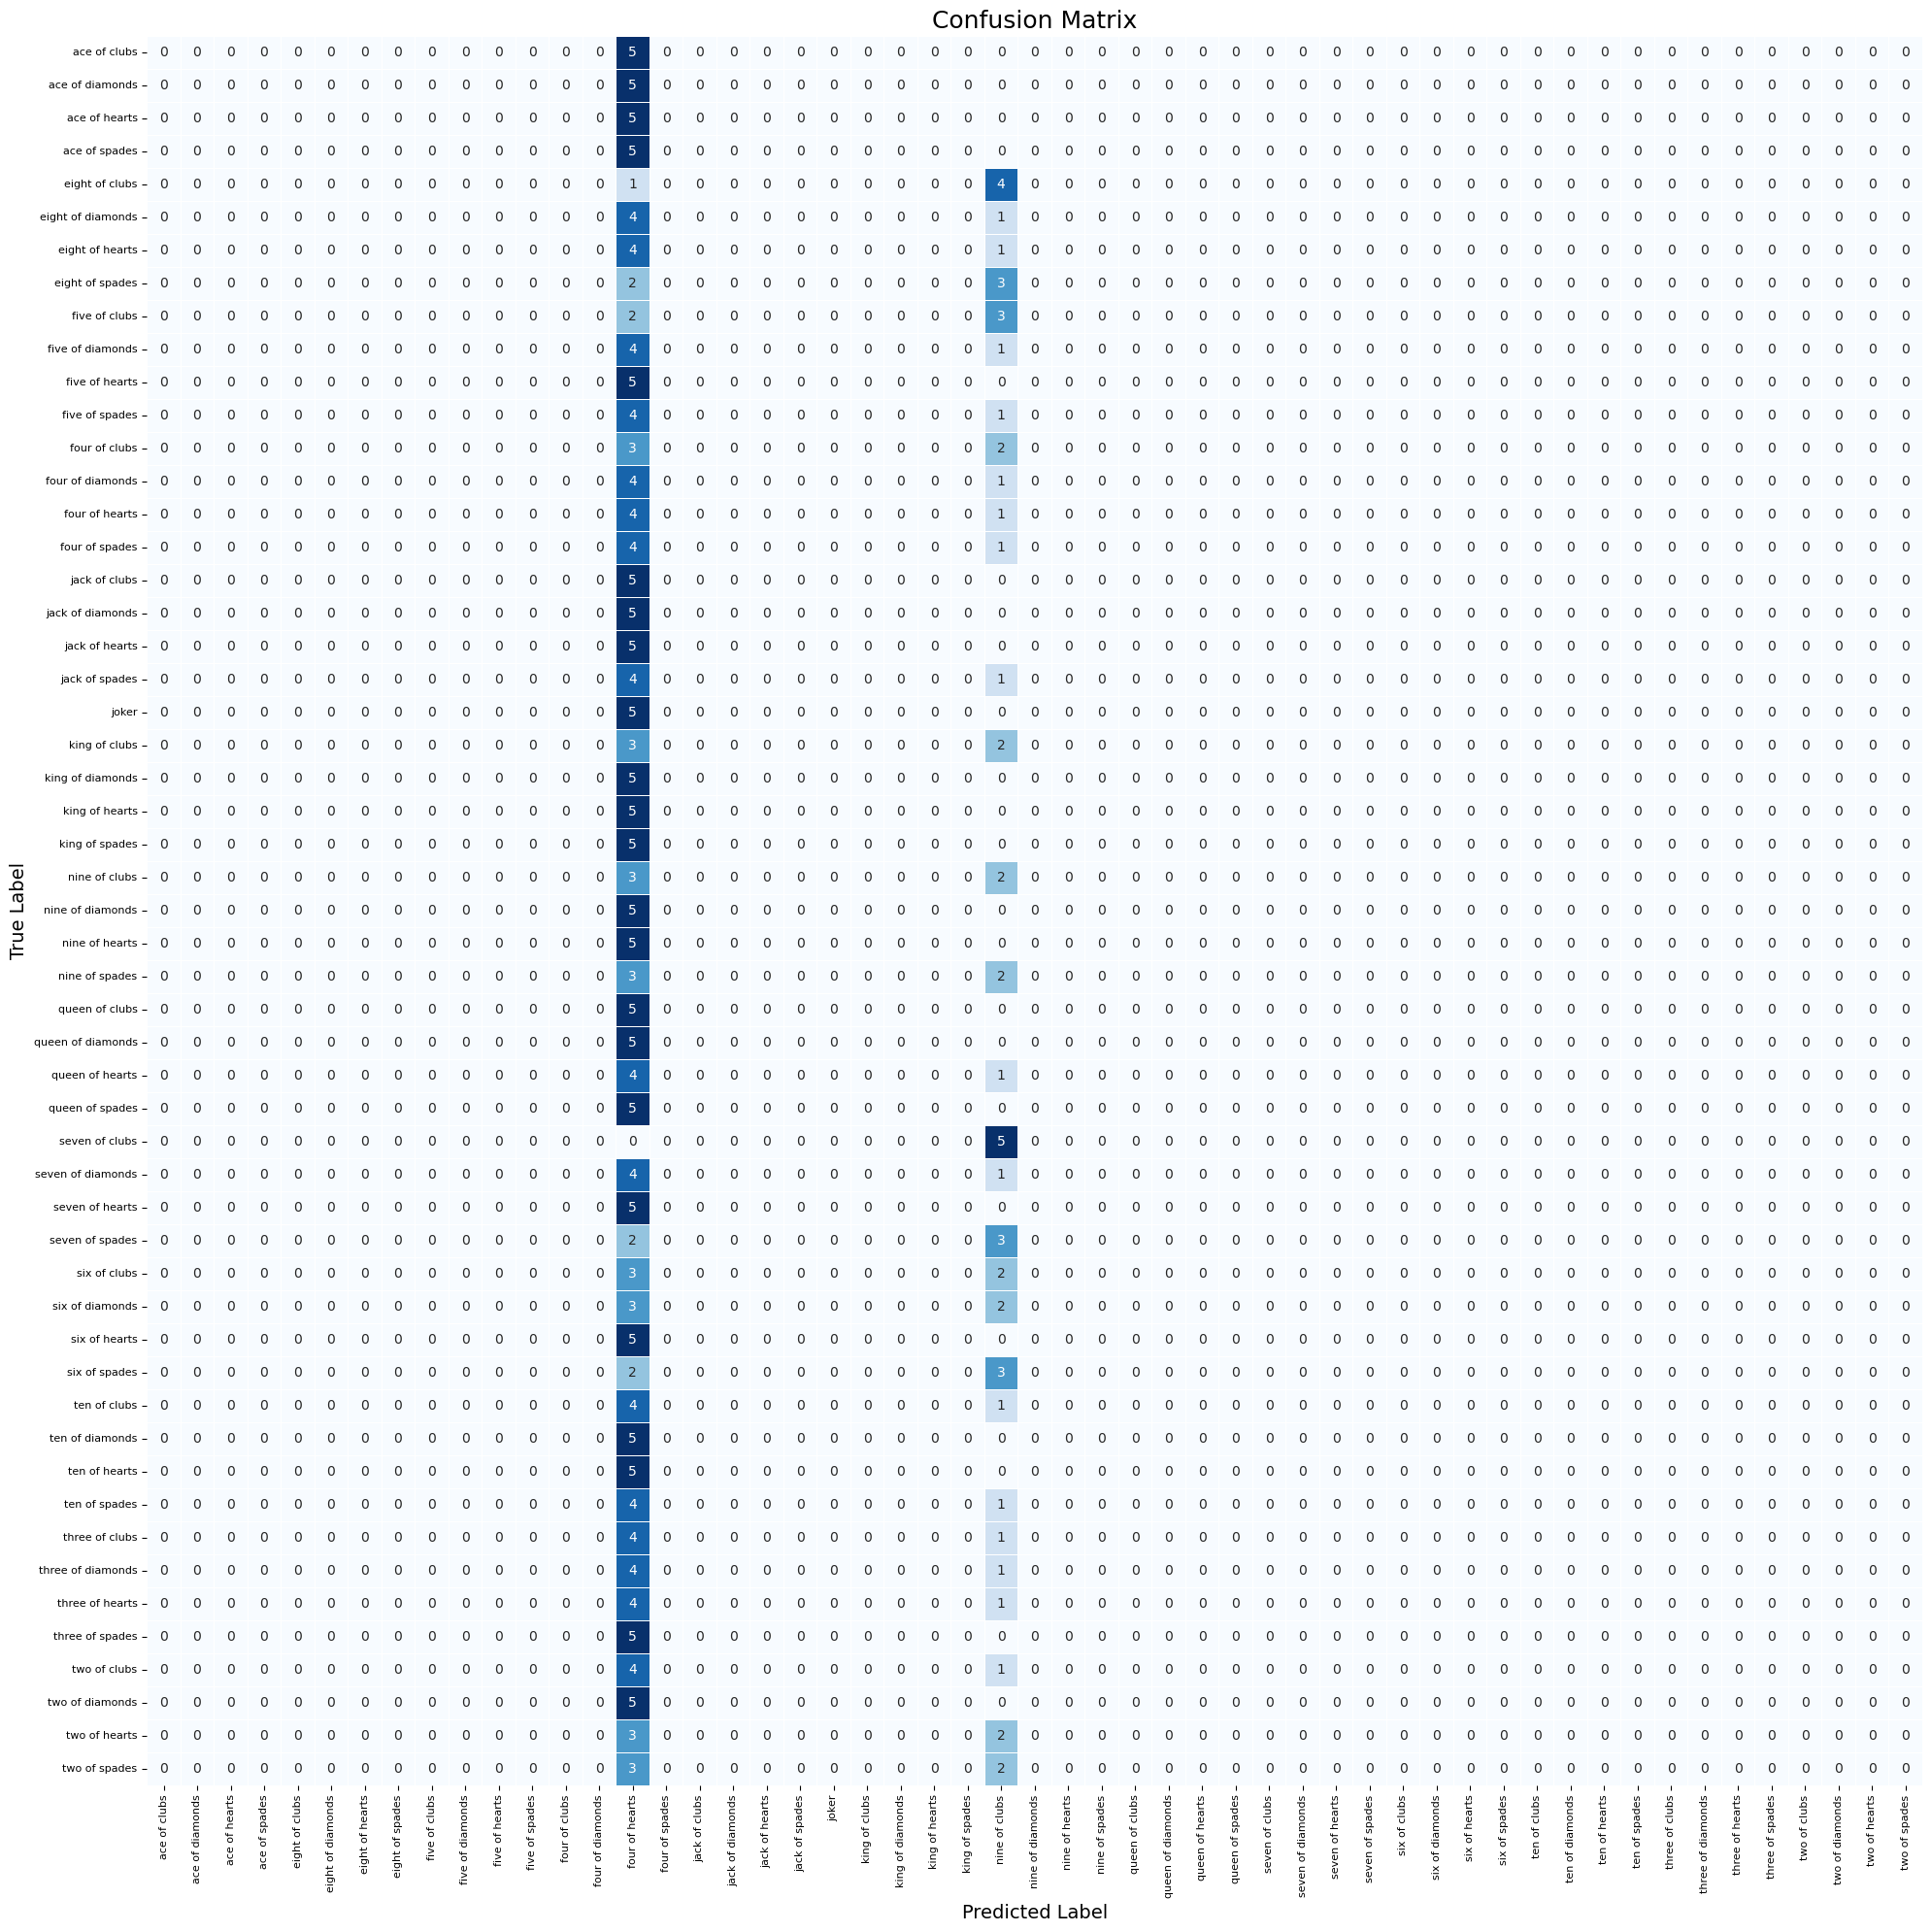

In [ ]:
evaluate_model(best_mobileNetV2, test_dataset)

In [ ]:
# best_mobileNetV2.save('../models/mobileNetV2_tuned.h5')

# HyperResNet Tuning

In [ ]:
# Preprocessing functins using resnet preprocessing function
def resNet_preprocess(image, label):
    image = keras.applications.resnet.preprocess_input(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def resNet_preprocess_augment(image, label):
    image, label = resNet_preprocess(image, label)
    image = img_augmentation(image)
    return image, label

In [ ]:
BATCH_SIZE = 16 # Batch has to be smaller because of the size of the model

# Reading images from folders
train_dataset = keras.utils.image_dataset_from_directory(TRAIN_DIR, image_size=(224, 224), batch_size=BATCH_SIZE)
test_dataset = keras.utils.image_dataset_from_directory(TEST_DIR, image_size=(224, 224), shuffle='false', batch_size=BATCH_SIZE)
val_dataset = keras.utils.image_dataset_from_directory(VAL_DIR, image_size=(224, 224), shuffle='flase', batch_size=BATCH_SIZE)

# Proprocessing training data
train_dataset = train_dataset.map(resNet_preprocess_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Proprocessing validation data
val_dataset = val_dataset.map(resNet_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Proprocessing testing data
test_dataset = test_dataset.map(resNet_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
tuner = Hyperband(
    HyperResNet(
        include_top=True,
        input_shape=IMG_SHAPE, 
        classes=NUM_CLASSES,
        ),
    objective='val_accuracy',
    directory= LOG_DIR + 'tuning/hyperResNet', 
    project_name='keras_tuner',   
)

In [ ]:
tuner.search(
    train_dataset,
    validation_data = val_dataset,
    callbacks = [
        TensorBoard(LOG_DIR + f'tuning/hyperResNet/tensorboard/{datetime.now().strftime("%Y%m%d-%H%M%S")}')
    ],
    verbose = 1
)

In [ ]:
# Displaying top 10 hyperparam configurations
best_hyperResNet_hps = tuner.get_best_hyperparameters(num_trials=10)
resNet_hp_list = []

for i, hp in enumerate(best_hyperResNet_hps, start=1):
    hp_dict = hp.values.copy()
    resNet_hp_list.append(hp_dict)

pd.DataFrame(resNet_hp_list)

In [ ]:
# Rebuilding the best model
best_hp = tuner.get_best_hyperparameters(num_trials=3)[2]
best_model = tuner.hypermodel.build(best_hp)


In [ ]:
training = best_model.fit(
    train_dataset, 
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = callbacks,
    verbose = 1,
)

In [ ]:
best_model.evaluate(test_dataset)

In [ ]:
plot_training_history(training)

In [ ]:
# best_model.save('../models/hyperResNet.h5')